## VODAFONE CUSTOMER CHURN ANALYSIS - TEAM PRETORIA - LP2

#### SETUP

##### INSTALLING RELEVAT LIBRARIES


%pip install database interaction library
%pip install pyodbc
%pip install plotly
%pip install statsmodels
%pip install imblearn 
%pip install openpyxl
%pip install phik
%pip install xgboost

#### IMPORTATION OF LIBRARIES 

In [14]:
##Data Handling
import pandas as pd
import numpy as np
import pyodbc
import statsmodels.api as sm

##Visualization Libraries 
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns 
import random
import plotly.offline as offline
offline.init_notebook_mode(connected=True) # Configure Plotly to run offline


# Feature Processing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import phik
from phik.report import plot_correlation_matrix
from phik import report

#Algorithms libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
import xgboost

##pipelines and transformers 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display="diagram")

##handling imbalance datasets
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

##hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

##for hypothesis testing 
from scipy.stats import chi2_contingency

##model evaluation:
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Other packages
from tabulate import tabulate
import os
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")
import pickle

## DATA LOADING

In [15]:
# create server instance variables
server = 'dap-projects-database.database.windows.net'
database = 'dapDB'
username = 'dataAnalyst_LP2'
password = 'A3g@3kR$2y'


#Establish connection with server 
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [16]:
#Connecting to the Server
connection = pyodbc.connect(connection_string)

In [17]:
#Get data from server with query 'Select *'
query = "Select * from dbo.LP2_Telco_churn_first_3000"
sql_data = pd.read_sql(query, connection)

In [18]:
sql_data.head()

customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0  7590-VHVEG  Female          False     True       False       1   
1  5575-GNVDE    Male          False    False       False      34   
2  3668-QPYBK    Male          False    False       False       2   
3  7795-CFOCW    Male          False    False       False      45   
4  9237-HQITU  Female          False    False       False       2   

   PhoneService MultipleLines InternetService OnlineSecurity  ...  \
0         False          None             DSL          False  ...   
1          True         False             DSL           True  ...   
2          True         False             DSL           True  ...   
3         False          None             DSL           True  ...   
4          True         False     Fiber optic          False  ...   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0            False       False       False           False  Month-to-month   
1             True       False       False           False        One year   
2            False       False       False           False  Month-to-month   
3             True        True       False           False        One year   
4            False       False       False           False  Month-to-month   

  PaperlessBilling              PaymentMethod MonthlyCharges  TotalCharges  \
0             True           Electronic check      29.850000     29.850000   
1            False               Mailed check      56.950001   1889.500000   
2             True               Mailed check      53.849998    108.150002   
3            False  Bank transfer (automatic)      42.299999   1840.750000   
4             True           Electronic check      70.699997    151.649994   

   Churn  
0  False  
1  False  
2   True  
3  False  
4   True  

[5 rows x 21 columns]

In [19]:
sql_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [20]:
#read csv for remaining data from GitHub repository
data = pd.read_csv('LP2_Telco-churn-last-2000.csv')
data.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  5600-PDUJF    Male              0      No         No       6          Yes   
1  8292-TYSPY    Male              0      No         No      19          Yes   
2  0567-XRHCU  Female              0     Yes        Yes      69           No   
3  1867-BDVFH    Male              0     Yes        Yes      11          Yes   
4  2067-QYTCF  Female              0     Yes         No      64          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0                No             DSL             No  ...               No   
1                No             DSL             No  ...              Yes   
2  No phone service             DSL            Yes  ...              Yes   
3               Yes     Fiber optic             No  ...               No   
4               Yes     Fiber optic             No  ...              Yes   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0         Yes          No              No  Month-to-month              Yes   
1         Yes          No              No  Month-to-month              Yes   
2          No          No             Yes        Two year              Yes   
3          No          No              No  Month-to-month              Yes   
4         Yes         Yes             Yes  Month-to-month              Yes   

             PaymentMethod MonthlyCharges  TotalCharges Churn  
0  Credit card (automatic)          49.50         312.7    No  
1  Credit card (automatic)          55.00        1046.5   Yes  
2  Credit card (automatic)          43.95        2960.1    No  
3         Electronic check          74.35         834.2   Yes  
4         Electronic check         111.15        6953.4    No  

[5 rows x 21 columns]

In [21]:
onedrive_data = pd.read_excel('Telco-churn-second-2000.xlsx')


In [22]:
#Merge dataset
voda_churn_train = pd.concat([sql_data, data])
voda_churn_train.to_csv('voda_customer_churn.csv')

#### EXPLORATORY DATA ANALYSIS 

Null Hypothesis: Customers with high monthly charges do not have the tendency to churn 

Alt Hypothesis: Customers with high monthly Charges have the tendency to churn 


Questions 
- How much total charges and Monthly charges did churners generate? 
- Are customers with dependents likely to have higher charges than those without dependents?
- How many Senior Citizens with dependents churn?
- Which internet service is most preferred?
- What is the most common payment method?

In [23]:
voda_df = pd.read_csv('voda_customer_churn.csv')

In [24]:
voda_df.head()

Unnamed: 0  customerID  gender SeniorCitizen Partner Dependents  tenure  \
0           0  7590-VHVEG  Female         False    True      False       1   
1           1  5575-GNVDE    Male         False   False      False      34   
2           2  3668-QPYBK    Male         False   False      False       2   
3           3  7795-CFOCW    Male         False   False      False      45   
4           4  9237-HQITU  Female         False   False      False       2   

  PhoneService MultipleLines InternetService  ... DeviceProtection  \
0        False           NaN             DSL  ...            False   
1         True         False             DSL  ...             True   
2         True         False             DSL  ...            False   
3        False           NaN             DSL  ...             True   
4         True         False     Fiber optic  ...            False   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0       False       False           False  Month-to-month             True   
1       False       False           False        One year            False   
2       False       False           False  Month-to-month             True   
3        True       False           False        One year            False   
4       False       False           False  Month-to-month             True   

               PaymentMethod MonthlyCharges        TotalCharges  Churn  
0           Electronic check      29.850000  29.850000381469727  False  
1               Mailed check      56.950001              1889.5  False  
2               Mailed check      53.849998   108.1500015258789   True  
3  Bank transfer (automatic)      42.299999             1840.75  False  
4           Electronic check      70.699997  151.64999389648438   True  

[5 rows x 22 columns]

In [25]:
voda_df.shape

(5043, 22)

In [26]:
voda_df = voda_df.drop('Unnamed: 0', axis = 'columns')

In [27]:
voda_df.shape

(5043, 21)

In [28]:
voda_df.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [29]:
#Checking the data types of the columns
voda_df.dtypes

customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [30]:
voda_df.describe()

tenure  MonthlyCharges
count  5043.000000     5043.000000
mean     32.576641       65.090214
std      24.529807       30.068133
min       0.000000       18.400000
25%       9.000000       35.775000
50%      29.000000       70.550003
75%      56.000000       90.050003
max      72.000000      118.650002

75% customers have tenure less than 56 months

Average Monthly charges are USD 65.09 whereas 25% customers pay more than USD 89.85 per month

Text(0.5, 1.0, 'Count of Target Variable per Category')

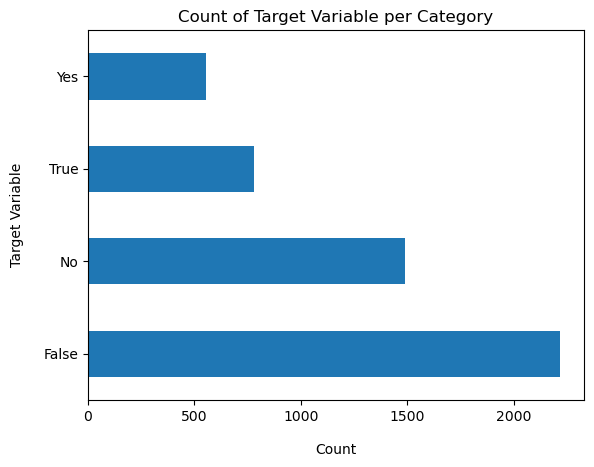

In [31]:
voda_df['Churn'].value_counts().plot(kind='barh')
plt.xlabel("Count", labelpad=14)
plt.ylabel("Target Variable", labelpad=14)
plt.title("Count of Target Variable per Category")

In [32]:
voda_df['Churn'].value_counts()

False    2219
No       1487
True      780
Yes       556
Name: Churn, dtype: int64

* The total value count is less than expected. Possibly missing values. Will be looked at during cleaning.
* Nonetheless, data looks highly imbalanced
* So we analyse the data with other features while taking the target values separately to get some insights.

In [33]:
# To have a concise look at the dataframe we will use verbose = True mode
voda_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   object 
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


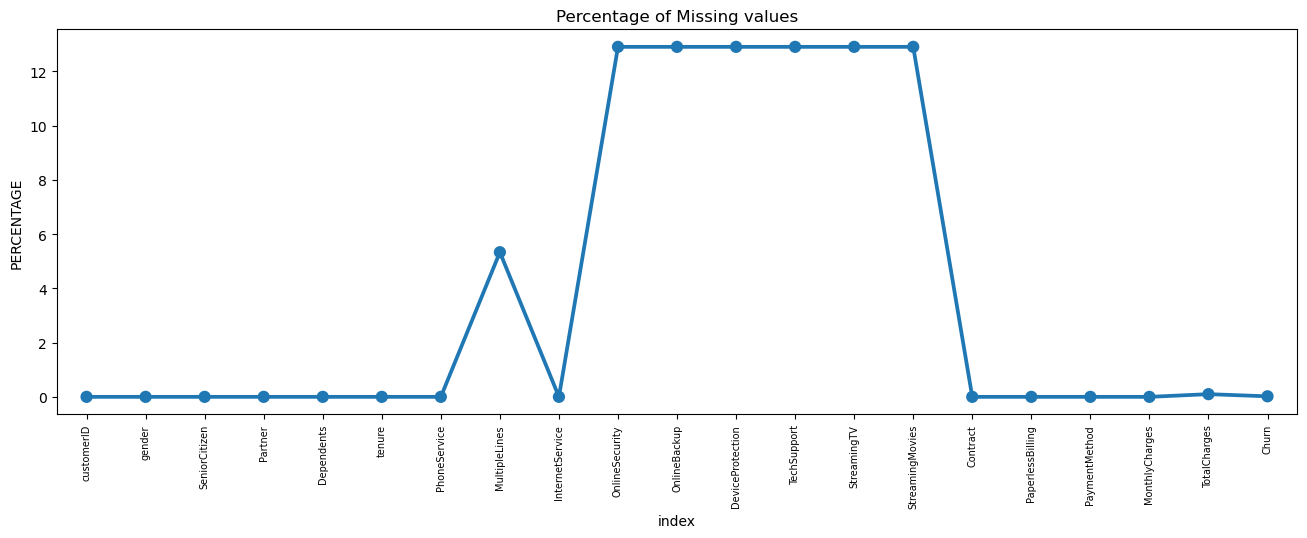

In [34]:
missing = pd.DataFrame((voda_df.isnull().sum())*100/voda_df.shape[0]).reset_index()
plt.figure(figsize=(16,5))
ax = sns.pointplot('index',0,data=missing)
plt.xticks(rotation =90,fontsize =7)
plt.title("Percentage of Missing values")
plt.ylabel("PERCENTAGE")
plt.show()

A point plot presentation of missing values in percentage shows our target variable has about 25% values missing. We would have to look at that in data cleaning

### Missing Data - Initial Intuition

General Thumb Rules:

* For features with less missing values- can use regression to predict the missing values or fill with the mean of the values present, depending on the feature.
* For features with very high number of missing values- it is better to drop those columns as they give very less insight on analysis.
* As there's no thumb rule on what criteria do we delete the columns with high number of missing values, but generally you can delete the columns, if you have more than 30-40% of missing values. But again there's a catch here, for example, Is_Car & Car_Type, People having no cars, will obviously have Car_Type as NaN (null), but that doesn't make this column useless, so decisions has to be taken wisely.

## Data Cleaning

#### Cleaning of Train Data

**1.** Create a copy of base data for manupulation & processing

In [35]:
voda_data = voda_df.copy()

**2** From Data understanding above we realized that Total Charges is object and needs to be changed to numeric

In [36]:
voda_data.TotalCharges = pd.to_numeric(voda_data.TotalCharges, errors='coerce')
voda_data.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 1
dtype: int64

**3** As we can see, there are 8 missing values in TotalCharges Column. Let us have a look at these records

In [37]:
voda_data.loc[voda_data['TotalCharges'].isnull() == True]

customerID  gender SeniorCitizen Partner Dependents  tenure  \
488   4472-LVYGI  Female         False    True       True       0   
753   3115-CZMZD    Male         False   False       True       0   
936   5709-LVOEQ  Female         False    True       True       0   
1082  4367-NUYAO    Male         False    True       True       0   
1340  1371-DWPAZ  Female         False    True       True       0   
3218  2923-ARZLG    Male             0     Yes        Yes       0   
4670  4075-WKNIU  Female             0     Yes        Yes       0   
4754  2775-SEFEE    Male             0      No        Yes       0   

     PhoneService MultipleLines InternetService       OnlineSecurity  ...  \
488         False           NaN             DSL                 True  ...   
753          True         False              No                  NaN  ...   
936          True         False             DSL                 True  ...   
1082         True          True              No                  NaN  ...   
1340        False           NaN             DSL                 True  ...   
3218          Yes            No              No  No internet service  ...   
4670          Yes           Yes             DSL                   No  ...   
4754          Yes           Yes             DSL                  Yes  ...   

         DeviceProtection          TechSupport          StreamingTV  \
488                  True                 True                 True   
753                   NaN                  NaN                  NaN   
936                  True                False                 True   
1082                  NaN                  NaN                  NaN   
1340                 True                 True                 True   
3218  No internet service  No internet service  No internet service   
4670                  Yes                  Yes                  Yes   
4754                   No                  Yes                   No   

          StreamingMovies  Contract PaperlessBilling  \
488                 False  Two year             True   
753                   NaN  Two year            False   
936                  True  Two year            False   
1082                  NaN  Two year            False   
1340                False  Two year            False   
3218  No internet service  One year              Yes   
4670                   No  Two year               No   
4754                   No  Two year              Yes   

                  PaymentMethod MonthlyCharges  TotalCharges  Churn  
488   Bank transfer (automatic)      52.549999           NaN  False  
753                Mailed check      20.250000           NaN  False  
936                Mailed check      80.849998           NaN  False  
1082               Mailed check      25.750000           NaN  False  
1340    Credit card (automatic)      56.049999           NaN  False  
3218               Mailed check      19.700000           NaN     No  
4670               Mailed check      73.350000           NaN     No  
4754  Bank transfer (automatic)      61.900000           NaN     No  

[8 rows x 21 columns]

**4** We would fill the missing values in the TotalCharges Column with the mean

In [38]:
voda_data['TotalCharges'].fillna(value= voda_data["TotalCharges"].mean(), inplace= True)

**5** We would fill the missing values in the TotalCharges Column with the mean

In [39]:
voda_data['Churn'].fillna(voda_data["Churn"].mode()[0], inplace= True)

**6** We are going to categorized the customers base on tenure e.g. for tenure < 12 months: assign a tenure group if 1-12, for tenure between 1 to 2 Yrs, tenure group of 13-24; so on...

In [40]:
#Get the max tenure
print(voda_data['tenure'].max())

72


In [41]:
#Group tenure in basket of 12 months
labels = ["{0} - {1}".format(i, i + 11) for i in range(1, 72, 12)]

voda_data['tenure_group'] = pd.cut(voda_data.tenure, range(1,84,12), right=False, labels=labels)

In [42]:
#View basket
voda_data['tenure_group'].value_counts()

1 - 12     1534
61 - 72    1017
13 - 24     732
25 - 36     603
49 - 60     590
37 - 48     559
Name: tenure_group, dtype: int64

**7** Drop columns not required for processing

In [43]:
#Drop the column CustomerID and tenure
voda_data.drop(columns=['customerID','tenure'],axis=1,inplace=True)
voda_data.head()

gender SeniorCitizen Partner Dependents PhoneService MultipleLines  \
0  Female         False    True      False        False           NaN   
1    Male         False   False      False         True         False   
2    Male         False   False      False         True         False   
3    Male         False   False      False        False           NaN   
4  Female         False   False      False         True         False   

  InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0             DSL          False         True            False       False   
1             DSL           True        False             True       False   
2             DSL           True         True            False       False   
3             DSL           True        False             True        True   
4     Fiber optic          False        False            False       False   

  StreamingTV StreamingMovies        Contract PaperlessBilling  \
0       False           False  Month-to-month             True   
1       False           False        One year            False   
2       False           False  Month-to-month             True   
3       False           False        One year            False   
4       False           False  Month-to-month             True   

               PaymentMethod  MonthlyCharges  TotalCharges  Churn tenure_group  
0           Electronic check       29.850000     29.850000  False       1 - 12  
1               Mailed check       56.950001   1889.500000  False      25 - 36  
2               Mailed check       53.849998    108.150002   True       1 - 12  
3  Bank transfer (automatic)       42.299999   1840.750000  False      37 - 48  
4           Electronic check       70.699997    151.649994   True       1 - 12

**8** Unifying the Churn Column Values

In [44]:
#Churn Column
voda_data['Churn'] = voda_data['Churn'].str.replace('False', 'No')
voda_data['Churn'] = voda_data['Churn'].str.replace('True', 'Yes')

#Senior Citizen Column 
voda_data['SeniorCitizen'] = voda_data['SeniorCitizen'].str.replace( '0','False')
voda_data['SeniorCitizen'] = voda_data['SeniorCitizen'].str.replace('1','True')

#Partner Column 
voda_data['Partner'] = voda_data['Partner'].str.replace('False', 'No')
voda_data['Partner'] = voda_data['Partner'].str.replace('True', 'Yes')

#Online Security 
voda_data['OnlineSecurity'] = voda_data['OnlineSecurity'].str.replace('False', 'No')
voda_data['OnlineSecurity'] = voda_data['OnlineSecurity'].str.replace('True', 'Yes')

#Dependents Column
voda_data['Dependents'] = voda_data['Dependents'].str.replace('False', 'No')
voda_data['Dependents'] = voda_data['Dependents'].str.replace('True', 'Yes')

#PhoneService Column
voda_data['PhoneService'] = voda_data['PhoneService'].str.replace('False', 'No')
voda_data['PhoneService'] = voda_data['PhoneService'].str.replace('True', 'Yes')

#MultipleLines Column
voda_data['MultipleLines'] = voda_data['MultipleLines'].str.replace('False', 'No')
voda_data['MultipleLines'] = voda_data['MultipleLines'].str.replace('True', 'Yes')

#Online Backup 
voda_data['OnlineBackup'] = voda_data['OnlineBackup'].str.replace('False', 'No')
voda_data['OnlineBackup'] = voda_data['OnlineBackup'].str.replace('True', 'Yes')

#DeviceProtection
voda_data['DeviceProtection'] = voda_data['DeviceProtection'].str.replace('False', 'No')
voda_data['DeviceProtection'] = voda_data['DeviceProtection'].str.replace('True', 'Yes')

#TechSupport
voda_data['TechSupport'] = voda_data['TechSupport'].str.replace('False', 'No')
voda_data['TechSupport'] = voda_data['TechSupport'].str.replace('True', 'Yes')

#TechSupport
voda_data['TechSupport'] = voda_data['TechSupport'].str.replace('False', 'No')
voda_data['TechSupport'] = voda_data['TechSupport'].str.replace('True', 'Yes')

#StreamingTV
voda_data['StreamingTV'] = voda_data['StreamingTV'].str.replace('False', 'No')
voda_data['StreamingTV'] = voda_data['StreamingTV'].str.replace('True', 'Yes')

#StreamingMovies
voda_data['StreamingMovies'] = voda_data['StreamingMovies'].str.replace('False', 'No')
voda_data['StreamingMovies'] = voda_data['StreamingMovies'].str.replace('True', 'Yes')

#PaperlessBilling
voda_data['PaperlessBilling'] = voda_data['PaperlessBilling'].str.replace('False', 'No')
voda_data['PaperlessBilling'] = voda_data['PaperlessBilling'].str.replace('True', 'Yes')

#### Cleaning of Test Data

**1.** Create a copy of base data for manupulation & processing

In [45]:
onedrive_data.head()

customerID gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7613-LLQFO   Male              0      No         No      12          Yes   
1  4568-TTZRT   Male              0      No         No       9          Yes   
2  9513-DXHDA   Male              0      No         No      27          Yes   
3  2640-PMGFL   Male              0      No        Yes      27          Yes   
4  3801-HMYNL   Male              0     Yes        Yes       1          Yes   

  MultipleLines InternetService       OnlineSecurity         OnlineBackup  \
0           Yes     Fiber optic                   No                   No   
1            No              No  No internet service  No internet service   
2            No             DSL                  Yes                   No   
3           Yes     Fiber optic                   No                   No   
4            No     Fiber optic                   No                   No   

      DeviceProtection          TechSupport          StreamingTV  \
0                   No                   No                  Yes   
1  No internet service  No internet service  No internet service   
2                  Yes                  Yes                  Yes   
3                   No                  Yes                   No   
4                   No                   No                  Yes   

       StreamingMovies        Contract PaperlessBilling     PaymentMethod  \
0                   No  Month-to-month              Yes  Electronic check   
1  No internet service  Month-to-month               No      Mailed check   
2                  Yes        One year               No  Electronic check   
3                   No  Month-to-month              Yes  Electronic check   
4                  Yes  Month-to-month               No      Mailed check   

   MonthlyCharges TotalCharges  
0           84.45      1059.55  
1           20.40        181.8  
2           81.70      2212.55  
3           79.50      2180.55  
4           89.15        89.15

In [46]:
onedrive_df = onedrive_data.copy()

**2** Checking for missing values

In [47]:
onedrive_df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

From Data understanding above, we realized that there are no missing values

**3** We are going to categorized the customers base on tenure e.g. for tenure < 12 months: assign a tenure group if 1-12, for tenure between 1 to 2 Yrs, tenure group of 13-24; so on...

In [48]:
#Get the max tenure
print(onedrive_df['tenure'].max())

72


In [49]:
#Group tenure in basket of 12 months
labels = ["{0} - {1}".format(i, i + 11) for i in range(1, 72, 12)]

onedrive_df['tenure_group'] = pd.cut(onedrive_df.tenure, range(1,84,12), right=False, labels=labels)

In [50]:
#View basket
onedrive_df['tenure_group'].value_counts()

1 - 12     641
61 - 72    390
13 - 24    292
49 - 60    242
25 - 36    229
37 - 48    203
Name: tenure_group, dtype: int64

**4** Drop columns not required for processing

In [51]:
#Drop the column CustomerID and tenure
onedrive_df.drop(columns=['customerID','tenure'],axis=1,inplace=True)
onedrive_df.head()

gender  SeniorCitizen Partner Dependents PhoneService MultipleLines  \
0   Male              0      No         No          Yes           Yes   
1   Male              0      No         No          Yes            No   
2   Male              0      No         No          Yes            No   
3   Male              0      No        Yes          Yes           Yes   
4   Male              0     Yes        Yes          Yes            No   

  InternetService       OnlineSecurity         OnlineBackup  \
0     Fiber optic                   No                   No   
1              No  No internet service  No internet service   
2             DSL                  Yes                   No   
3     Fiber optic                   No                   No   
4     Fiber optic                   No                   No   

      DeviceProtection          TechSupport          StreamingTV  \
0                   No                   No                  Yes   
1  No internet service  No internet service  No internet service   
2                  Yes                  Yes                  Yes   
3                   No                  Yes                   No   
4                   No                   No                  Yes   

       StreamingMovies        Contract PaperlessBilling     PaymentMethod  \
0                   No  Month-to-month              Yes  Electronic check   
1  No internet service  Month-to-month               No      Mailed check   
2                  Yes        One year               No  Electronic check   
3                   No  Month-to-month              Yes  Electronic check   
4                  Yes  Month-to-month               No      Mailed check   

   MonthlyCharges TotalCharges tenure_group  
0           84.45      1059.55       1 - 12  
1           20.40        181.8       1 - 12  
2           81.70      2212.55      25 - 36  
3           79.50      2180.55      25 - 36  
4           89.15        89.15       1 - 12

**5** Unifying the Churn Column Values

In [52]:
#Partner Column 
onedrive_df['Partner'] = onedrive_df['Partner'].str.replace('False', 'No')
onedrive_df['Partner'] = onedrive_df['Partner'].str.replace('True', 'Yes')

#Online Security 
onedrive_df['OnlineSecurity'] = onedrive_df['OnlineSecurity'].str.replace('False', 'No')
onedrive_df['OnlineSecurity'] = onedrive_df['OnlineSecurity'].str.replace('True', 'Yes')

#Dependents Column
onedrive_df['Dependents'] = onedrive_df['Dependents'].str.replace('False', 'No')
onedrive_df['Dependents'] = onedrive_df['Dependents'].str.replace('True', 'Yes')

#PhoneService Column
onedrive_df['PhoneService'] = onedrive_df['PhoneService'].str.replace('False', 'No')
onedrive_df['PhoneService'] = onedrive_df['PhoneService'].str.replace('True', 'Yes')

#MultipleLines Column
onedrive_df['MultipleLines'] = onedrive_df['MultipleLines'].str.replace('False', 'No')
onedrive_df['MultipleLines'] = onedrive_df['MultipleLines'].str.replace('True', 'Yes')

#Online Backup 
onedrive_df['OnlineBackup'] = onedrive_df['OnlineBackup'].str.replace('False', 'No')
onedrive_df['OnlineBackup'] = onedrive_df['OnlineBackup'].str.replace('True', 'Yes')

#DeviceProtection
onedrive_df['DeviceProtection'] = onedrive_df['DeviceProtection'].str.replace('False', 'No')
onedrive_df['DeviceProtection'] = onedrive_df['DeviceProtection'].str.replace('True', 'Yes')

#TechSupport
onedrive_df['TechSupport'] = onedrive_df['TechSupport'].str.replace('False', 'No')
onedrive_df['TechSupport'] = onedrive_df['TechSupport'].str.replace('True', 'Yes')

#TechSupport
onedrive_df['TechSupport'] = onedrive_df['TechSupport'].str.replace('False', 'No')
onedrive_df['TechSupport'] = onedrive_df['TechSupport'].str.replace('True', 'Yes')

#StreamingTV
onedrive_df['StreamingTV'] = onedrive_df['StreamingTV'].str.replace('False', 'No')
onedrive_df['StreamingTV'] = onedrive_df['StreamingTV'].str.replace('True', 'Yes')

#StreamingMovies
onedrive_df['StreamingMovies'] = onedrive_df['StreamingMovies'].str.replace('False', 'No')
onedrive_df['StreamingMovies'] = onedrive_df['StreamingMovies'].str.replace('True', 'Yes')

#PaperlessBilling
onedrive_df['PaperlessBilling'] = onedrive_df['PaperlessBilling'].str.replace('False', 'No')
onedrive_df['PaperlessBilling'] = onedrive_df['PaperlessBilling'].str.replace('True', 'Yes')

## Data Exploration

**1** Plot of individual predictors by churn

### Univariate Analysis

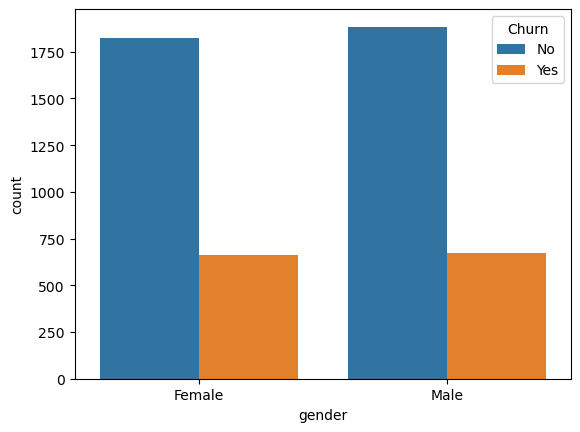

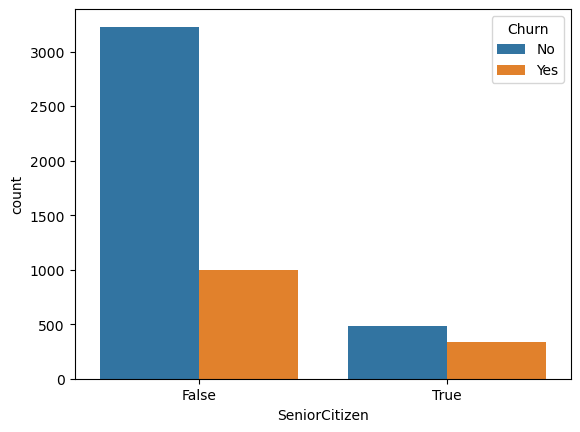

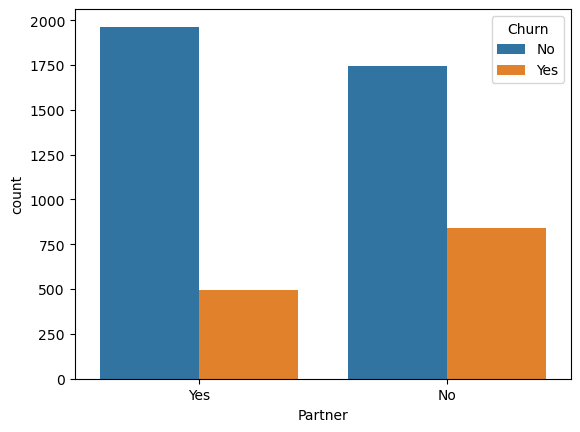

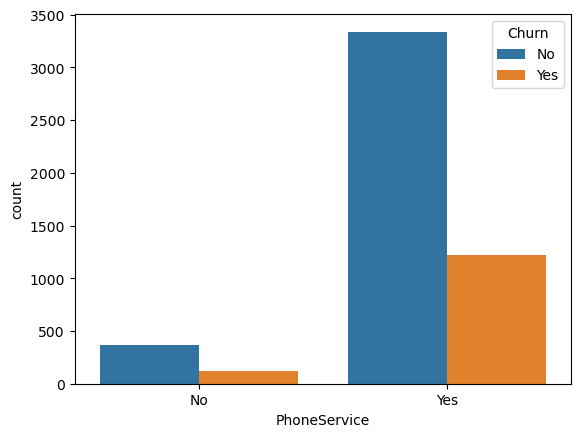

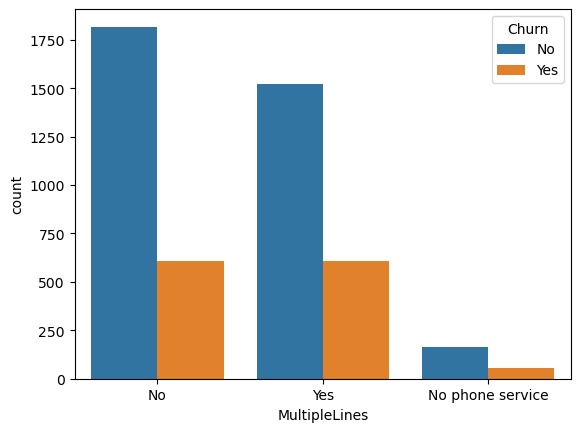

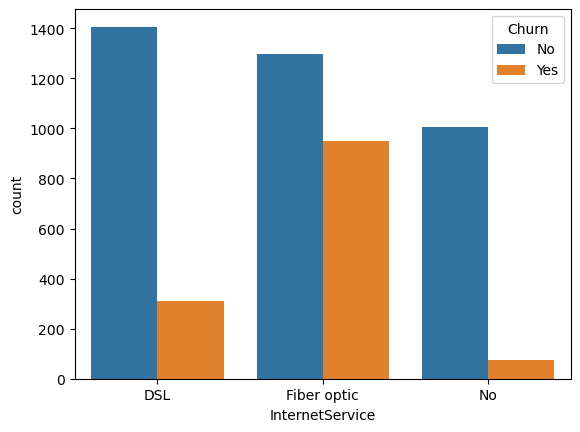

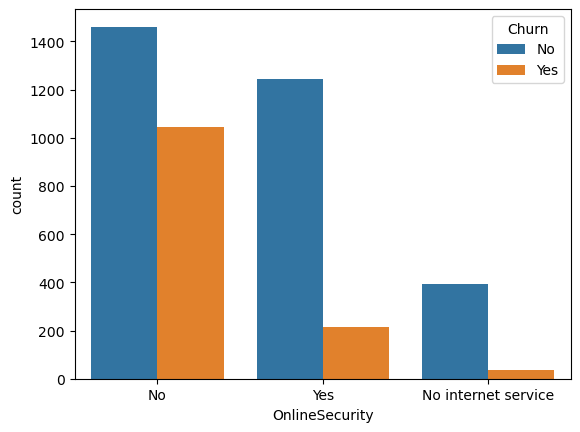

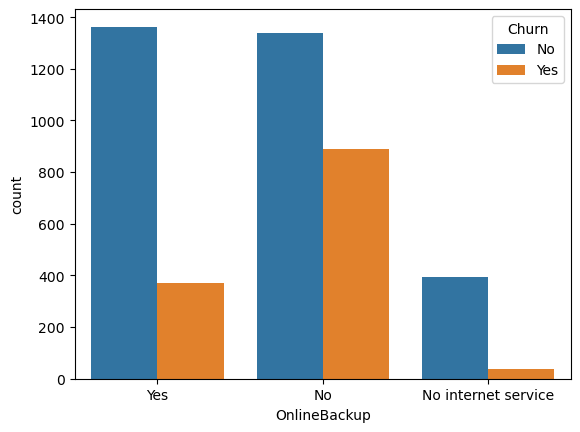

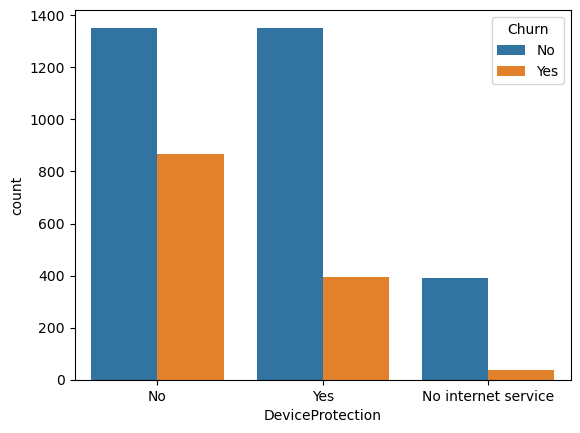

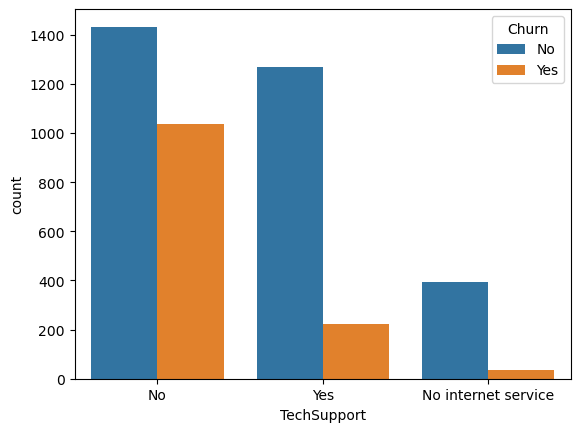

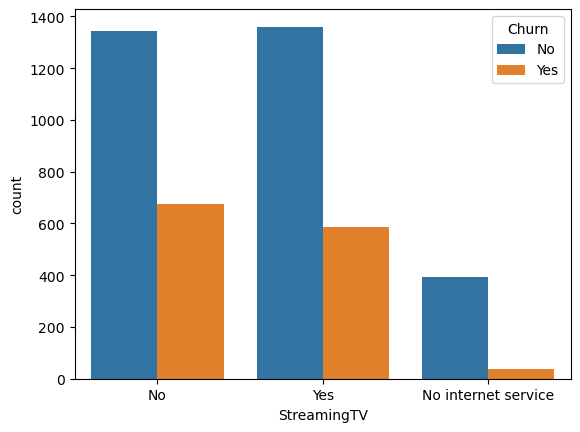

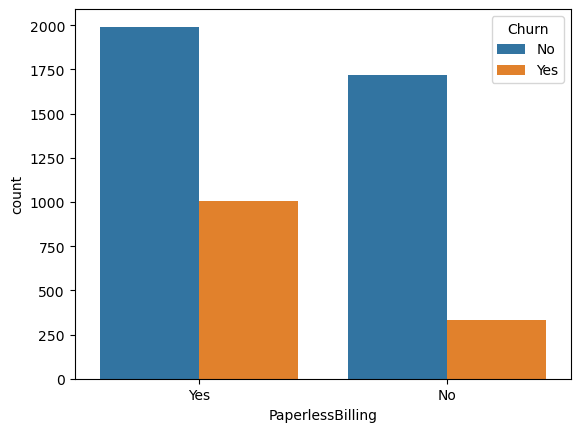

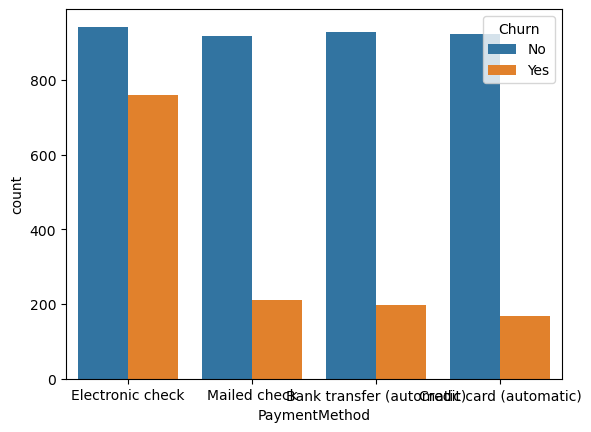

In [53]:
for i, predictor in enumerate(voda_data.drop(columns=['Churn', 'TotalCharges', 'MonthlyCharges'])):
    plt.figure(i)
    sns.countplot(data=voda_data, x=predictor, hue='Churn')

**2** Relationship between Monthly Charges and Total Charges

In [54]:
sns.lmplot(data=voda_data, x='MonthlyCharges', y='TotalCharges', fit_reg=False)

It could be observed that as Total Charges increases, Monthly Charges increases as expected

**3** Churn by Monthly Charges and Total Charges

Text(0.5, 1.0, 'Monthly charges by churn')

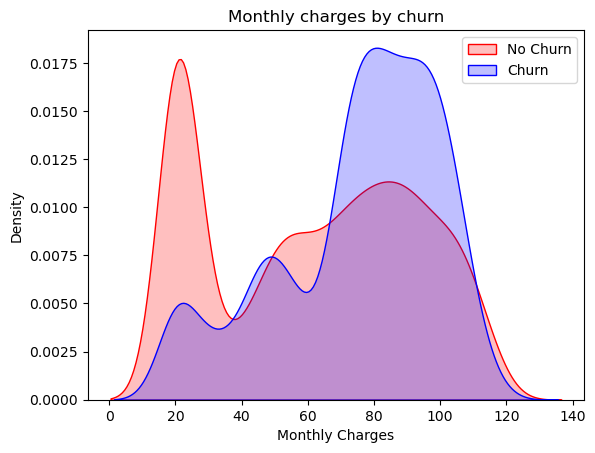

In [55]:
Mth = sns.kdeplot(voda_data.MonthlyCharges[(voda_data["Churn"] == "No") ],
                color="Red", shade = True)
Mth = sns.kdeplot(voda_data.MonthlyCharges[(voda_data["Churn"] == "Yes") ],
                ax =Mth, color="Blue", shade= True)
Mth.legend(["No Churn","Churn"],loc='upper right')
Mth.set_ylabel('Density')
Mth.set_xlabel('Monthly Charges')
Mth.set_title('Monthly charges by churn')

**Insight:** Churn is high when Monthly Charges are high

In [56]:
Tot = sns.kdeplot(voda_data.TotalCharges[(voda_data["Churn"] == "No") ],
                color="Red", shade = True)
Tot = sns.kdeplot(voda_data.TotalCharges[(voda_data["Churn"] == "Yes") ],
                ax =Tot, color="Blue", shade= True)
Tot.legend(["No Churn","Churn"],loc='upper right')
Tot.set_ylabel('Density')
Tot.set_xlabel('Total Charges')
Tot.set_title('Total charges by churn')

Text(0.5, 1.0, 'Total charges by churn')

**Surprising insight ** Higher Churn at lower Total Charges

However if we combine the insights of 3 parameters i.e. Tenure, Monthly Charges & Total Charges then the picture is bit clear :- Higher Monthly Charge at lower tenure results into lower Total Charge. Hence, all these 3 factors viz **Higher Monthly Charge**,  **Lower tenure** and **Lower Total Charge** are linkd to **High Churn**.

### Bivariate Analysis

In [57]:
new_df1_target0 = voda_data.loc[voda_data["Churn"] == "No"]
new_df1_target1 = voda_data.loc[voda_data["Churn"] == "Yes"]

In [58]:
def uniplot(df,col,title,hue =None):
    
    sns.set_style('whitegrid')
    sns.set_context('talk')
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams['axes.titlesize'] = 22
    plt.rcParams['axes.titlepad'] = 30
    
    
    temp = pd.Series(data = hue)
    fig, ax = plt.subplots()
    width = len(df[col].unique()) + 7 + 4*len(temp.unique())
    fig.set_size_inches(width , 8)
    plt.xticks(rotation=45)
    plt.yscale('log')
    plt.title(title)
    ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue,palette='bright') 
        
    plt.show()

In [59]:
uniplot(new_df1_target1,col='Partner',title='Distribution of Gender for Churned Customers',hue='gender')

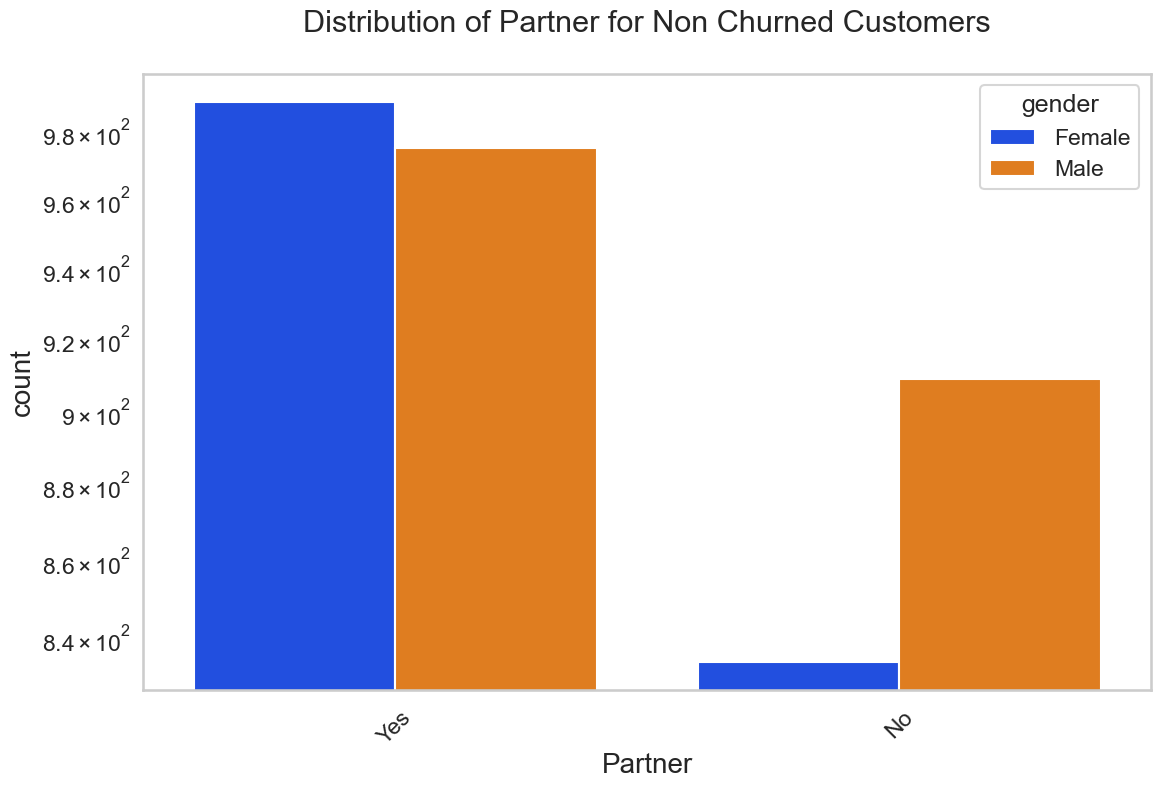

In [60]:
uniplot(new_df1_target0,col='Partner',title='Distribution of Partner for Non Churned Customers',hue='gender')

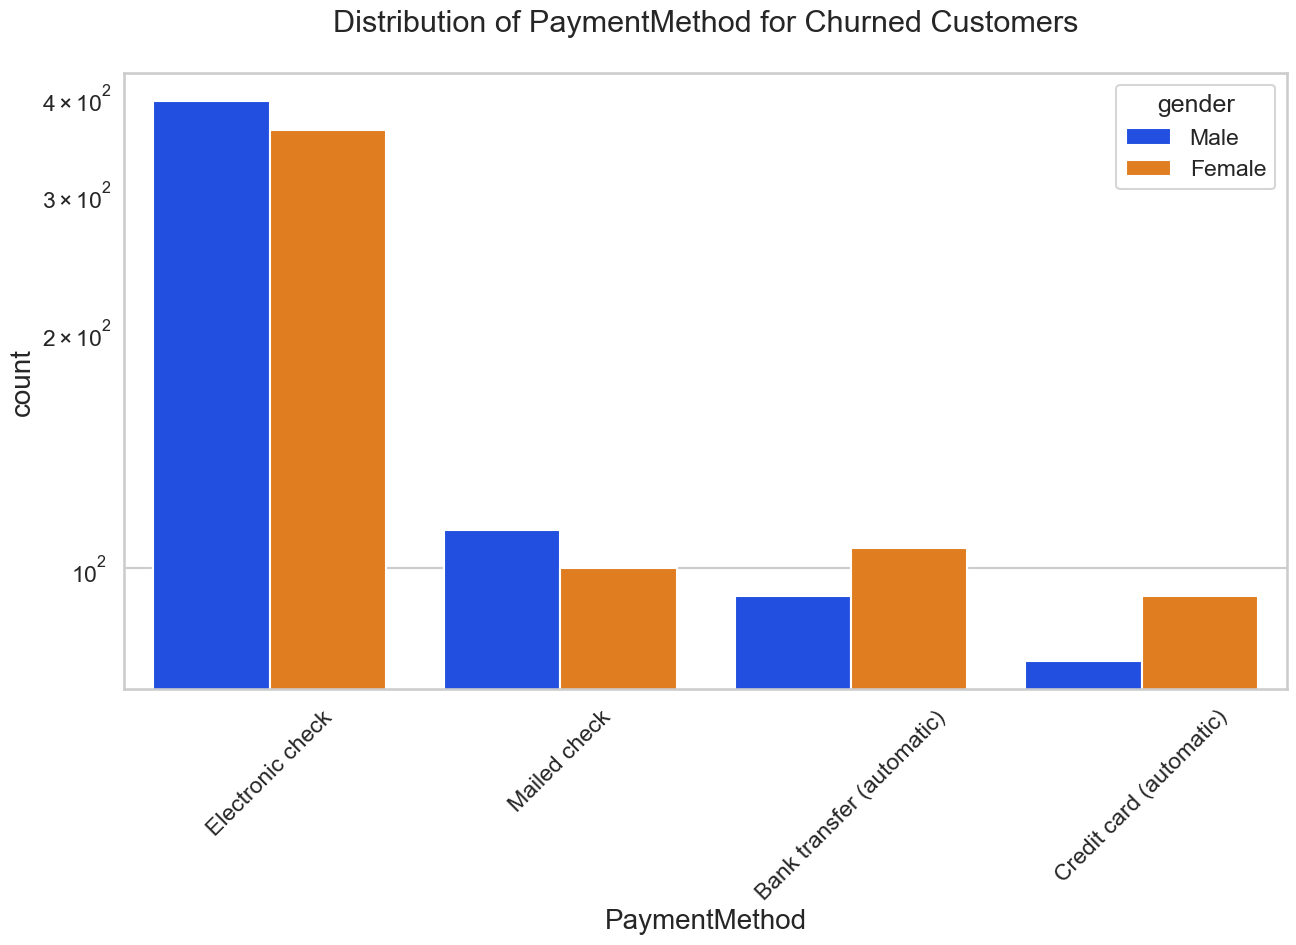

In [61]:
uniplot(new_df1_target1,col='PaymentMethod',title='Distribution of PaymentMethod for Churned Customers',hue='gender')

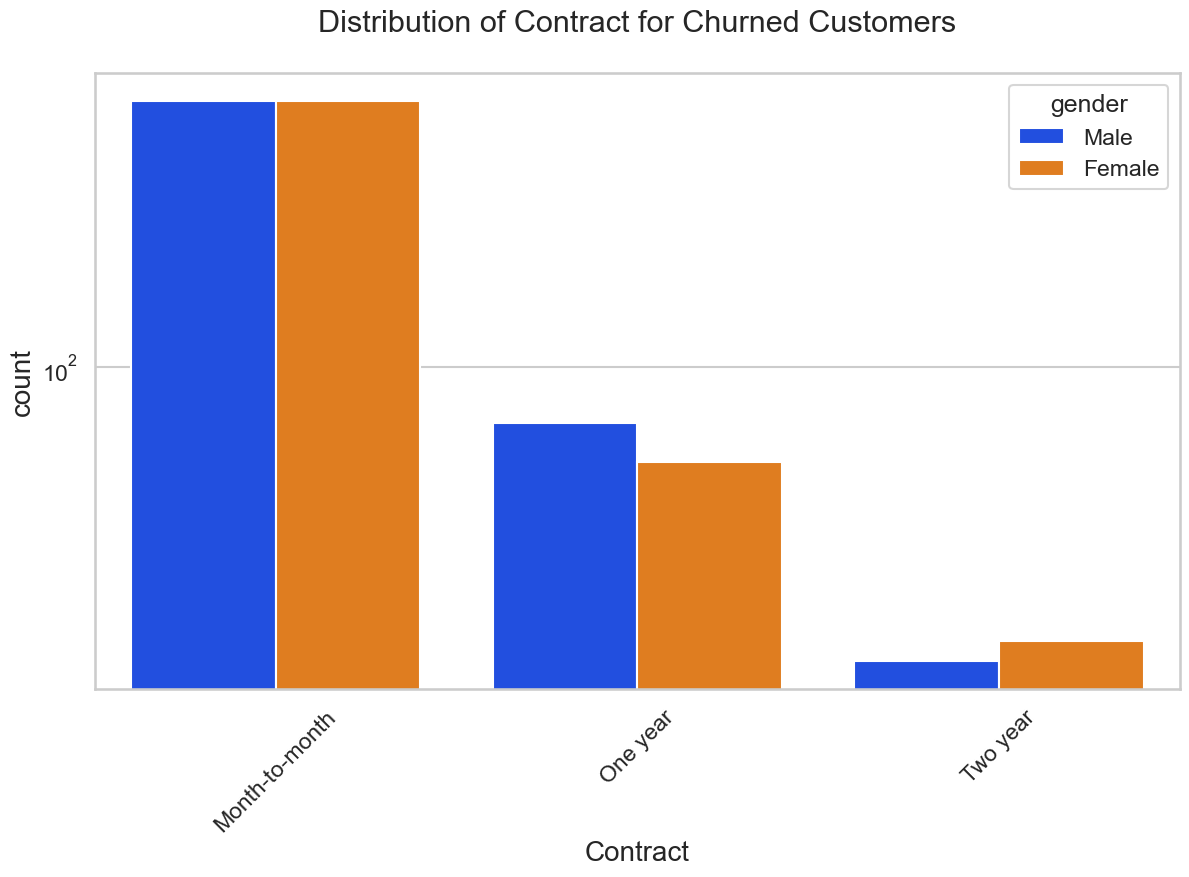

In [62]:
uniplot(new_df1_target1,col='Contract',title='Distribution of Contract for Churned Customers',hue='gender')

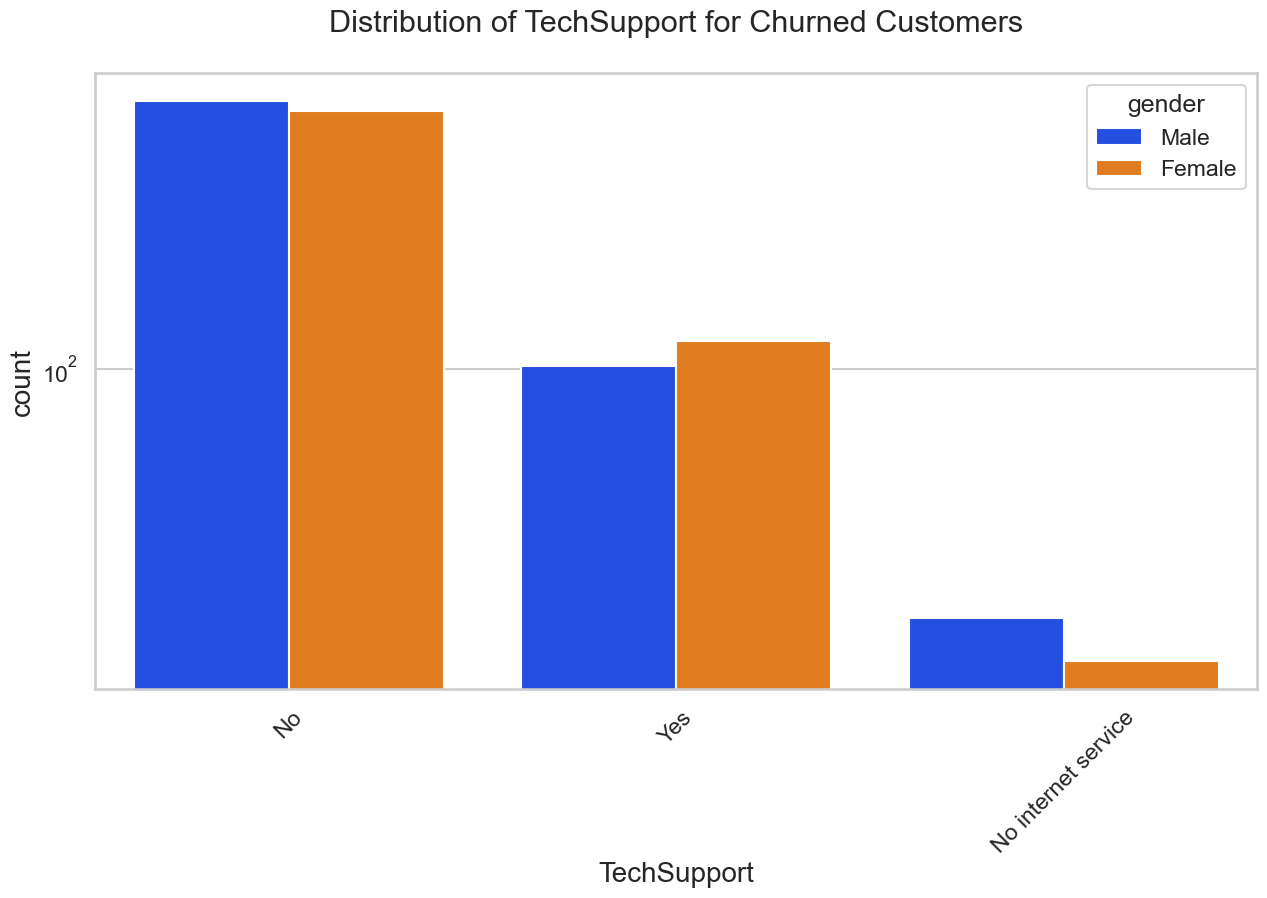

In [63]:
uniplot(new_df1_target1,col='TechSupport',title='Distribution of TechSupport for Churned Customers',hue='gender')

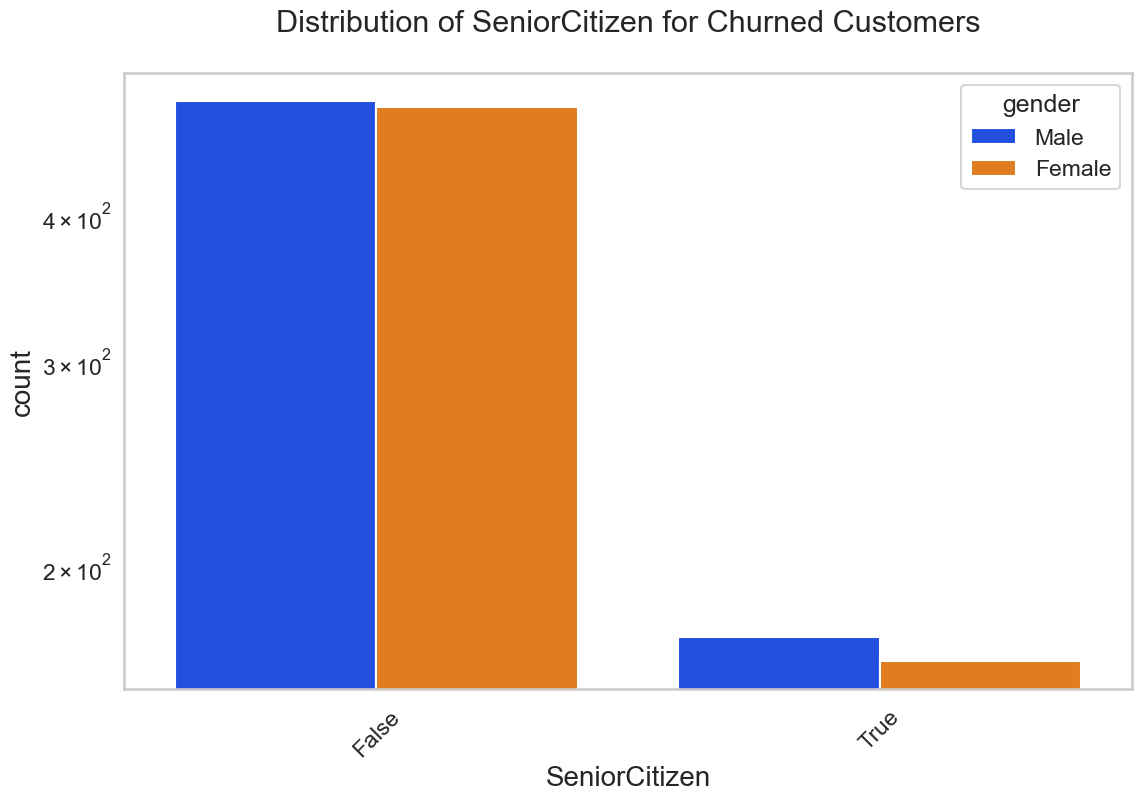

In [64]:
uniplot(new_df1_target1,col='SeniorCitizen',title='Distribution of SeniorCitizen for Churned Customers',hue='gender')

# CONCLUSIONS FROM EDA

These are some of the quick insights from this exercise:

1. Electronic check medium are the highest churners
2. Contract Type - Monthly customers are more likely to churn because of no contract terms, as they are free to go customers.
3. No Online security, No Tech Support category are high churners
4. Non senior Citizens are high churners

# ANSWERING ANALYTICAL QUESTIONS 

#### 1. How much revenue did churners generate?

In [66]:
churn_df= voda_data[voda_data["Churn"]== "Yes"]
amount = churn_df.agg({"MonthlyCharges": "sum", "TotalCharges": "sum"}).reset_index()

amount.columns = ["Charge", "Amount"]

fig = px.bar(data_frame= amount, x= "Charge",
       y= "Amount", title= "Revenue Generated By Churners", text= "Amount", color= "Charge",
             color_discrete_sequence= ["red", "blue"])
fig.show()

Here we can see that Churners Generate a monthly revenue of Ghc 100,481.90 and a Total Revenue of Ghc 2,092,874.25

#### 2. Are customers with dependents likely to have higher charges than those with dependents?

In [67]:
# Group Customers with Dependency and total charges
cus_depdts = px.box(data_frame = voda_data, x='Dependents', y='TotalCharges', color='Dependents',
             category_orders={'Dependents': ['No', 'Yes']})
cus_depdts.update_layout(title='Distribution of Total Charges by Dependents Status',
                  xaxis_title='Dependents', yaxis_title='Total Charges')
cus_depdts.show()

From the Boxplot we can see that people with dependants have incure higher charges with an average charge of Ghc 1,601.25 than people without dependents with average charge of Ghc 1,322.5

#### 3. How many senior citizens with dependents churn?

In [68]:
Senior_dept = voda_data[(voda_data["Churn"]== "Yes")&(voda_data["Dependents"]== "Yes")]
snrc_dep = px.histogram(x="SeniorCitizen", data_frame=Senior_dept, color= "SeniorCitizen", color_discrete_sequence=["rosybrown", "plum"], 
             title= "Senior Citizen with Dependents Who Churned")
snrc_dep.show()

We realise that the number of Senior Citizen who have dependents are 237 and 16 of them Churn. 

#### 4. Which Internet Service is most preferred?

In [78]:
#Group customer ID by internet services 
inter_serv = voda_data.groupby('InternetService')['gender'].count().reset_index()
inter_serv.rename(columns={'gender':'Count'}, inplace =True)
inter_serv

InternetService  Count
0             DSL   1715
1     Fiber optic   2248
2              No   1080

In [79]:
#Visualizing 
count_inter_serv = inter_serv['Count']
Product = inter_serv['InternetService']

fig = px.pie(values=count_inter_serv, names=Product, title='Most Preferred InternetService ', 
             color_discrete_sequence=px.colors.sequential.Redor, 
             labels={'value': 'Count'})

fig.update_traces(textposition='inside', textinfo='percent+label') 
fig.show()

The most preferred internet Service is Fiber Obtic

#### 5. What is the most common payment method?

In [80]:
sns.countplot(x = "PaymentMethod", data = voda_data, palette= "bright"  )
plt.title("Plot of Count of Payment Methods")
plt.xticks(rotation= 45)
plt.figure(figsize= (10,5))
plt.show()

<Figure size 1000x500 with 0 Axes>

According to our Bargraph we can deduce that the most common Payment method is Electronic Check

#### Saving datasets to csv

In [81]:
voda_data.to_csv('train.csv')

In [82]:
onedrive_df.to_csv('test.csv')

# Feature Engineering

#### Reading csv

In [83]:
train_data=pd.read_csv("train.csv")

In [84]:
train_data=train_data.drop('Unnamed: 0',axis=1)

### Step 1: Data Splitting

In [85]:
X=train_data.drop('Churn',axis=1)
X

gender  SeniorCitizen Partner Dependents PhoneService     MultipleLines  \
0     Female          False     Yes         No           No               NaN   
1       Male          False      No         No          Yes                No   
2       Male          False      No         No          Yes                No   
3       Male          False      No         No           No               NaN   
4     Female          False      No         No          Yes                No   
...      ...            ...     ...        ...          ...               ...   
5038    Male          False     Yes        Yes          Yes               Yes   
5039  Female          False     Yes        Yes          Yes               Yes   
5040  Female          False     Yes        Yes           No  No phone service   
5041    Male           True     Yes         No          Yes               Yes   
5042    Male          False      No         No          Yes                No   

     InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0                DSL             No          Yes               No          No   
1                DSL            Yes           No              Yes          No   
2                DSL            Yes          Yes               No          No   
3                DSL            Yes           No              Yes         Yes   
4        Fiber optic             No           No               No          No   
...              ...            ...          ...              ...         ...   
5038             DSL            Yes           No              Yes         Yes   
5039     Fiber optic             No          Yes              Yes          No   
5040             DSL            Yes           No               No          No   
5041     Fiber optic             No           No               No          No   
5042     Fiber optic            Yes           No              Yes         Yes   

     StreamingTV StreamingMovies        Contract PaperlessBilling  \
0             No              No  Month-to-month              Yes   
1             No              No        One year               No   
2             No              No  Month-to-month              Yes   
3             No              No        One year               No   
4             No              No  Month-to-month              Yes   
...          ...             ...             ...              ...   
5038         Yes             Yes        One year              Yes   
5039         Yes             Yes        One year              Yes   
5040          No              No  Month-to-month              Yes   
5041          No              No  Month-to-month              Yes   
5042         Yes             Yes        Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges tenure_group  
0              Electronic check       29.850000     29.850000       1 - 12  
1                  Mailed check       56.950001   1889.500000      25 - 36  
2                  Mailed check       53.849998    108.150002       1 - 12  
3     Bank transfer (automatic)       42.299999   1840.750000      37 - 48  
4              Electronic check       70.699997    151.649994       1 - 12  
...                         ...             ...           ...          ...  
5038               Mailed check       84.800000   1990.500000      13 - 24  
5039    Credit card (automatic)      103.200000   7362.900000      61 - 72  
5040           Electronic check       29.600000    346.450000       1 - 12  
5041               Mailed check       74.400000    306.600000       1 - 12  
5042  Bank transfer (automatic)      105.650000   6844.500000      61 - 72  

[5043 rows x 19 columns]

In [86]:
y=train_data['Churn']
y

0        No
1        No
2       Yes
3        No
4       Yes
       ... 
5038     No
5039     No
5040     No
5041    Yes
5042     No
Name: Churn, Length: 5043, dtype: object

In [87]:
# Declaring variables/ attributes to be used for our pipelines

NUMERICAL = list(set(X.select_dtypes('number').columns))

print(f"Numerical features: {', '.join(NUMERICAL)}")

CATEGORICAL = list(set(X.select_dtypes(exclude= 'number').columns))

print(f"Categorical features: {', '.join(CATEGORICAL)}")

Numerical features: TotalCharges, MonthlyCharges
Categorical features: DeviceProtection, PhoneService, PaymentMethod, Contract, SeniorCitizen, StreamingMovies, TechSupport, tenure_group, StreamingTV, PaperlessBilling, Partner, Dependents, gender, OnlineBackup, OnlineSecurity, MultipleLines, InternetService


In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [89]:
###converting our label to a numeric variable for easy analysis 

LE= LabelEncoder() ##initializing the model


num_y_train= LE.fit_transform(y_train) ##fitting and transforming on the train data

num_y_test= LE.transform(y_test) ##transforming on the test data

In [90]:
y_train = num_y_train

y_test = num_y_test

In [91]:
### handling the empty space. The aim of the this function is to replace the missing values with NaN values

def remove_space(in_train_data):
    in_train_data["TotalCharges"]= in_train_data["TotalCharges"].replace(r"^\s*$", np.nan, regex= True)
    return in_train_data

In [92]:
"""Since we cannot fit and transform the function above, we will create a class with the function embedded to help 

us call, fit, and transform with the function above"""

class SpaceImputer():
    def __init__(self,func):
        self.func= func
    
    def transform(self, in_train_data, **transform_params):
        return self.func(in_train_data)
    
    def fit(self, X, y=None, **fit_params):
        return self
        

# Model Building

### Creating Pipelines

In [93]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

In [94]:
preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, NUMERICAL),
    ('cat', categorical_pipeline, CATEGORICAL)
])

### DecisionTree CLassifier

In [95]:
model_dt = Pipeline([
    ('spaceImputer', SpaceImputer(remove_space)),
    ('preprocessors', preprocessors),
    ('model', DecisionTreeClassifier(random_state = 100,max_depth=6, min_samples_leaf=8))
])

In [96]:
model_dt.fit(X_train, num_y_train)

Pipeline(steps=[('spaceImputer',
                 <__main__.SpaceImputer object at 0x0000025A81CD8E80>),
                ('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['DeviceProtection',
                                                   'PhoneService',
                                                   'PaymentMethod', 'Contract',
                                                   'SeniorCitizen',
                                                   'StreamingMovies',
                                                   'TechSupport',
                                                   'tenure_group',
                                                   'StreamingTV',
                                                   'PaperlessBilling',
                                                   'Partner', 'Dependents',
                                                   'gender', 'OnlineBackup',
                                                   'OnlineSecurity',
                                                   'MultipleLines',
                                                   'InternetService'])])),
                ('model',
                 DecisionTreeClassifier(max_depth=6, min_samples_leaf=8,
                                        random_state=100))])

In [97]:
y_predict0 = model_dt.predict(X_test)
y_predict0

array([0, 0, 0, ..., 1, 1, 1])

In [98]:
roc_auc0 = roc_auc_score(y_test ,y_predict0)
roc_auc0

0.7103713013719373

In [99]:
report = classification_report(y_test, y_predict0)

report += f"\nROC AUC Score: {roc_auc0:.4f}" 

print(report)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       742
           1       0.58      0.57      0.57       267

    accuracy                           0.78      1009
   macro avg       0.71      0.71      0.71      1009
weighted avg       0.77      0.78      0.77      1009

ROC AUC Score: 0.7104


As you can see that the accuracy is quite low, and as it's an imbalanced dataset, we shouldn't consider Accuracy as our metrics to measure the model, as Accuracy is cursed in imbalanced datasets.

Hence we check the ROC AUC score. measures the performance of a classification model based on the area under the ROC curve. It is a value between 0 and 1, with higher values indicating better model performance in distinguishing between positive and negative classes. From our populated score, we can see the score is quite low.

Furthermore, we need to check ROC AUC Score, recall, precision & f1 score for the minority class, and it's quite evident that the precision, recall & f1 score is too low for Class 1, i.e. churned customers.

Hence, moving ahead to call SMOTEENN (UpSampling + ENN)

##### Decision Tree  Classifier with balancing

In [100]:
model_dt_smote = Pipeline([("spaceImputer", SpaceImputer(remove_space)),
                           ('preprocessors', preprocessors),
                           ("smote", SMOTE(random_state=100)),  # Apply SMOTE for oversampling
                           ("model", DecisionTreeClassifier(random_state = 100, max_depth=6, min_samples_leaf=8))
                           ])

In [101]:
model_dt_smote.fit(X_train,y_train)

y_predict1 = model_dt_smote.predict(X_test)

roc_auc1 = roc_auc_score(y_test ,y_predict1)

report = classification_report(y_test, y_predict1)

report += f"\nROC AUC Score: {roc_auc1:.4f}" 

print(report)

              precision    recall  f1-score   support

           0       0.89      0.78      0.83       742
           1       0.54      0.73      0.62       267

    accuracy                           0.77      1009
   macro avg       0.72      0.75      0.73      1009
weighted avg       0.80      0.77      0.78      1009

ROC AUC Score: 0.7535


### Insights
Adding balance improves the model

Increase in the **non-churner(1)** Recall means less false negatives.

It worth noting that while recall on non-churners increased, precision decreased. This is ok thanks to the precision-recall trade off

### Let us try other models and evaluate

#### Random Forest Classifier

In [102]:
model_rf = Pipeline([("spaceImputer", SpaceImputer(remove_space)),
                           ('preprocessors', preprocessors),
                           ("model", RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100,max_depth=6, min_samples_leaf=8))
                           ])

In [103]:
model_rf.fit(X_train, y_train)

Pipeline(steps=[('spaceImputer',
                 <__main__.SpaceImputer object at 0x0000025A81CDFD60>),
                ('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['DeviceProtection',
                                                   'PhoneService',
                                                   'PaymentMethod', 'Contract',
                                                   'SeniorCitizen',
                                                   'StreamingMovies',
                                                   'TechSupport',
                                                   'tenure_group',
                                                   'StreamingTV',
                                                   'PaperlessBilling',
                                                   'Partner', 'Dependents',
                                                   'gender', 'OnlineBackup',
                                                   'OnlineSecurity',
                                                   'MultipleLines',
                                                   'InternetService'])])),
                ('model',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=8,
                                        random_state=100))])

In [104]:
y_predict2 = model_rf.predict(X_test)

In [105]:
roc_auc2 = roc_auc_score(y_test, y_predict2)

In [106]:
report = classification_report(y_test, y_predict2)

report += f"\nROC AUC Score: {roc_auc2:.4f}" 

print(report)

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       742
           1       0.67      0.49      0.57       267

    accuracy                           0.80      1009
   macro avg       0.75      0.70      0.72      1009
weighted avg       0.79      0.80      0.79      1009

ROC AUC Score: 0.7022


#### Random Forest Classifier with Balancing

In [107]:
model_rf_smote = Pipeline([("spaceImputer", SpaceImputer(remove_space)),
                           ('preprocessors', preprocessors),
                           ("smote", SMOTE(random_state=100)),  # Apply SMOTE for oversampling
                           ("model", RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100, max_depth=6, min_samples_leaf=8))
                           ])

In [108]:
model_rf_smote.fit(X_train, y_train)

Pipeline(steps=[('spaceImputer',
                 <__main__.SpaceImputer object at 0x0000025A81C9ACD0>),
                ('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),...
                                                   'PhoneService',
                                                   'PaymentMethod', 'Contract',
                                                   'SeniorCitizen',
                                                   'StreamingMovies',
                                                   'TechSupport',
                                                   'tenure_group',
                                                   'StreamingTV',
                                                   'PaperlessBilling',
                                                   'Partner', 'Dependents',
                                                   'gender', 'OnlineBackup',
                                                   'OnlineSecurity',
                                                   'MultipleLines',
                                                   'InternetService'])])),
                ('smote', SMOTE(random_state=100)),
                ('model',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=8,
                                        random_state=100))])

In [109]:
y_predict3 = model_rf_smote.predict(X_test)

In [110]:
roc_auc3 = roc_auc_score(y_test,y_predict3)

In [111]:
report = classification_report(y_test, y_predict3)

report += f"\nROC AUC Score: {roc_auc3:.4f}" 

print(report)

              precision    recall  f1-score   support

           0       0.90      0.75      0.82       742
           1       0.52      0.76      0.62       267

    accuracy                           0.75      1009
   macro avg       0.71      0.75      0.72      1009
weighted avg       0.80      0.75      0.76      1009

ROC AUC Score: 0.7541


#### Logistic Regression

In [112]:
model_lr = Pipeline([("spaceImputer", SpaceImputer(remove_space)),
                           ('preprocessors', preprocessors),
                           ("model", LogisticRegression(C=1.0, random_state = 100))
                           ])

In [113]:
model_lr.fit(X_train, y_train)

Pipeline(steps=[('spaceImputer',
                 <__main__.SpaceImputer object at 0x0000025A81D089A0>),
                ('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['DeviceProtection',
                                                   'PhoneService',
                                                   'PaymentMethod', 'Contract',
                                                   'SeniorCitizen',
                                                   'StreamingMovies',
                                                   'TechSupport',
                                                   'tenure_group',
                                                   'StreamingTV',
                                                   'PaperlessBilling',
                                                   'Partner', 'Dependents',
                                                   'gender', 'OnlineBackup',
                                                   'OnlineSecurity',
                                                   'MultipleLines',
                                                   'InternetService'])])),
                ('model', LogisticRegression(random_state=100))])

In [114]:
y_predict4 = model_lr.predict(X_test)

In [115]:
roc_auc4 = roc_auc_score(y_test, y_predict4)

In [116]:
report = classification_report(y_test, y_predict4)

report += f"\nROC AUC Score: {roc_auc4:.4f}" 

print(report)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       742
           1       0.66      0.56      0.61       267

    accuracy                           0.81      1009
   macro avg       0.75      0.73      0.74      1009
weighted avg       0.80      0.81      0.80      1009

ROC AUC Score: 0.7283


#### Logistic Regression With Balancing

In [117]:
model_lr_smote = Pipeline([("spaceImputer", SpaceImputer(remove_space)),
                           ('preprocessors', preprocessors),
                           ("smote", SMOTE(random_state=100)),  # Apply SMOTE for oversampling
                           ("model", LogisticRegression(C=1.0, random_state = 100))
                           ])

In [118]:
model_lr_smote.fit(X_train,y_train)

Pipeline(steps=[('spaceImputer',
                 <__main__.SpaceImputer object at 0x0000025A81D086A0>),
                ('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['DeviceProtection',
                                                   'PhoneService',
                                                   'PaymentMethod', 'Contract',
                                                   'SeniorCitizen',
                                                   'StreamingMovies',
                                                   'TechSupport',
                                                   'tenure_group',
                                                   'StreamingTV',
                                                   'PaperlessBilling',
                                                   'Partner', 'Dependents',
                                                   'gender', 'OnlineBackup',
                                                   'OnlineSecurity',
                                                   'MultipleLines',
                                                   'InternetService'])])),
                ('smote', SMOTE(random_state=100)),
                ('model', LogisticRegression(random_state=100))])

In [119]:
y_predict5 = model_lr_smote.predict(X_test)

In [120]:
roc_auc5 = roc_auc_score(y_test, y_predict5)

In [121]:
report = classification_report(y_test, y_predict5)

report += f"\nROC AUC Score: {roc_auc5:.4f}"

print(report)

              precision    recall  f1-score   support

           0       0.90      0.73      0.80       742
           1       0.51      0.79      0.62       267

    accuracy                           0.74      1009
   macro avg       0.71      0.76      0.71      1009
weighted avg       0.80      0.74      0.76      1009

ROC AUC Score: 0.7558


#### Gradient Boosting Classifier Model

In [122]:
model_gb = Pipeline([("spaceImputer", SpaceImputer(remove_space)),
                           ('preprocessors', preprocessors),
                           ("model", GradientBoostingClassifier(criterion='friedman_mse', random_state = 100,max_depth=6, min_samples_leaf=8))
                           ])

In [123]:
model_gb.fit(X_train, y_train)

Pipeline(steps=[('spaceImputer',
                 <__main__.SpaceImputer object at 0x0000025A81D085B0>),
                ('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['DeviceProtection',
                                                   'PhoneService',
                                                   'PaymentMethod', 'Contract',
                                                   'SeniorCitizen',
                                                   'StreamingMovies',
                                                   'TechSupport',
                                                   'tenure_group',
                                                   'StreamingTV',
                                                   'PaperlessBilling',
                                                   'Partner', 'Dependents',
                                                   'gender', 'OnlineBackup',
                                                   'OnlineSecurity',
                                                   'MultipleLines',
                                                   'InternetService'])])),
                ('model',
                 GradientBoostingClassifier(max_depth=6, min_samples_leaf=8,
                                            random_state=100))])

In [124]:
y_predict6 = model_gb.predict(X_test)

In [125]:
roc_auc6 = roc_auc_score(y_test, y_predict6)

In [126]:
report = classification_report(y_test, y_predict6)

report += f"\nROC AUC Score: {roc_auc6:.4f}" 

print(report)

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       742
           1       0.62      0.54      0.58       267

    accuracy                           0.79      1009
   macro avg       0.73      0.71      0.72      1009
weighted avg       0.78      0.79      0.79      1009

ROC AUC Score: 0.7122


#### Gradient Boosting Classifier Model With Balancing

In [127]:
model_gb_smote = Pipeline([("spaceImputer", SpaceImputer(remove_space)),
                           ('preprocessors', preprocessors),
                           ("smote", SMOTE(random_state=100)),  # Apply SMOTE for oversampling
                           ("model", GradientBoostingClassifier(criterion='friedman_mse', random_state = 100,max_depth=6, min_samples_leaf=8))
                           ])

In [128]:
model_gb_smote.fit(X_train, y_train)

Pipeline(steps=[('spaceImputer',
                 <__main__.SpaceImputer object at 0x0000025A81D14430>),
                ('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),...
                                                   'PhoneService',
                                                   'PaymentMethod', 'Contract',
                                                   'SeniorCitizen',
                                                   'StreamingMovies',
                                                   'TechSupport',
                                                   'tenure_group',
                                                   'StreamingTV',
                                                   'PaperlessBilling',
                                                   'Partner', 'Dependents',
                                                   'gender', 'OnlineBackup',
                                                   'OnlineSecurity',
                                                   'MultipleLines',
                                                   'InternetService'])])),
                ('smote', SMOTE(random_state=100)),
                ('model',
                 GradientBoostingClassifier(max_depth=6, min_samples_leaf=8,
                                            random_state=100))])

In [129]:
y_predict7 = model_gb_smote.predict(X_test)

In [130]:
roc_auc7 = roc_auc_score(y_test, y_predict7)

In [131]:
report = classification_report(y_test, y_predict7)

report += f"\nROC AUC Score: {roc_auc7:.4f}"

print(report)

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       742
           1       0.60      0.61      0.61       267

    accuracy                           0.79      1009
   macro avg       0.73      0.73      0.73      1009
weighted avg       0.79      0.79      0.79      1009

ROC AUC Score: 0.7319


In [132]:
model_xgb = Pipeline([("spaceImputer", SpaceImputer(remove_space)),
                    ('preprocessors', preprocessors),
                    ("model", XGBClassifier(random_state = 100))
                    ])

In [133]:
model_xgb.fit(X_train, y_train)

Pipeline(steps=[('spaceImputer',
                 <__main__.SpaceImputer object at 0x0000025A81D1D640>),
                ('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=100, ...))])

In [134]:
y_predict8 = model_xgb.predict(X_test)

In [135]:
roc_auc8 = roc_auc_score(y_test, y_predict8)

In [136]:
report = classification_report(y_test, y_predict8)

report += f"\nROC AUC Score: {roc_auc8:.4f}"

print(report)

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       742
           1       0.60      0.54      0.57       267

    accuracy                           0.78      1009
   macro avg       0.72      0.70      0.71      1009
weighted avg       0.78      0.78      0.78      1009

ROC AUC Score: 0.7038


In [137]:
model_xgb_smote = Pipeline([("spaceImputer", SpaceImputer(remove_space)),
                           ('preprocessors', preprocessors),
                           ("smote", SMOTE(random_state=100)),  # Apply SMOTE for oversampling
                           ("model", XGBClassifier(random_state = 100))
                           ])

In [138]:
model_xgb_smote.fit(X_train, y_train)

Pipeline(steps=[('spaceImputer',
                 <__main__.SpaceImputer object at 0x0000025A81D1D880>),
                ('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=100, ...))])

In [139]:
y_predict9 = model_xgb_smote.predict(X_test)

In [140]:
roc_auc9 = roc_auc_score(y_test, y_predict9)

In [141]:
report = classification_report(y_test, y_predict9)

report += f"\nROC AUC Score: {roc_auc9:.4f}"

print(report)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       742
           1       0.59      0.59      0.59       267

    accuracy                           0.78      1009
   macro avg       0.72      0.72      0.72      1009
weighted avg       0.78      0.78      0.78      1009

ROC AUC Score: 0.7231


## Model Evaluation

In [142]:
metrics_df = pd.DataFrame(columns=['Model', 'ROC_AUC', 'Precision', 'Recall', 'F1 Score'])

### Looking at classifiers without balancing

In [143]:
models = [
    (model_dt, 'Decision Tree'),
    (model_rf, 'Random Forest'),
    (model_gb, 'Gradient Boosting'),
    (model_lr, 'Logistic Regression'),
    (model_xgb, 'XGB')
]

metrics_df = pd.DataFrame(columns=['Model', 'ROC_AUC', 'Precision', 'Recall', 'F1 Score'])

for model, model_name in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    roc_auc = roc_auc_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    metrics_df = metrics_df.append({'Model': model_name, 'ROC_AUC': roc_auc,
                                    'Precision': precision, 'Recall': recall, 'F1 Score': f1}, ignore_index=True)
    
    metrics_df = metrics_df.sort_values(by='F1 Score', ascending=False)

metrics_df

Model   ROC_AUC  Precision    Recall  F1 Score
0  Logistic Regression  0.728338   0.657895  0.561798  0.606061
1    Gradient Boosting  0.712236   0.622318  0.543071  0.580000
2        Decision Tree  0.710371   0.575188  0.573034  0.574109
3        Random Forest  0.702192   0.671795  0.490637  0.567100
4                  XGB  0.703774   0.600840  0.535581  0.566337

### Looking at Classifiers with balancing

In [144]:
models = [
    (model_dt_smote, 'Decision Tree Bal'),
    (model_rf_smote, 'Random Forest Bal'),
    (model_gb_smote, 'Gradient Boosting Bal'),
    (model_lr_smote, 'Logistic Regression Bal'),
    (model_xgb_smote, 'XGB Bal')
]

metrics_bal_df = pd.DataFrame(columns=['Model', 'ROC_AUC', 'Precision', 'Recall', 'F1 Score'])

for model, model_name in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    roc_auc = roc_auc_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    metrics_bal_df = metrics_bal_df.append({'Model': model_name, 'ROC_AUC': roc_auc,
                                    'Precision': precision, 'Recall': recall, 'F1 Score': f1}, ignore_index=True)
    
    metrics_bal_df = metrics_bal_df.sort_values(by='F1 Score', ascending=False)

metrics_bal_df

Model   ROC_AUC  Precision    Recall  F1 Score
0        Decision Tree Bal  0.753458   0.543417  0.726592  0.621795
1        Random Forest Bal  0.754139   0.520513  0.760300  0.617960
2  Logistic Regression Bal  0.755792   0.507246  0.786517  0.616740
3    Gradient Boosting Bal  0.731942   0.604478  0.606742  0.605607
4                  XGB Bal  0.723104   0.593985  0.591760  0.592871

INSIGHTS:
From the two tables, the following observations were made
* Balancing the target variables improves the performance of our models
* The two best models we used based on F1 scores are Gradient Boosting Classifier (with balancing) and Random Forest Classifier (with balancing)

## Hyperparameter Tuning

In [145]:
models = [model_dt_smote, model_rf_smote]

#### Tuning Gradient Boosting Classifier Model

In [146]:
model_dt_smote

Pipeline(steps=[('spaceImputer',
                 <__main__.SpaceImputer object at 0x0000025A81CD8430>),
                ('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),...
                                                   'PhoneService',
                                                   'PaymentMethod', 'Contract',
                                                   'SeniorCitizen',
                                                   'StreamingMovies',
                                                   'TechSupport',
                                                   'tenure_group',
                                                   'StreamingTV',
                                                   'PaperlessBilling',
                                                   'Partner', 'Dependents',
                                                   'gender', 'OnlineBackup',
                                                   'OnlineSecurity',
                                                   'MultipleLines',
                                                   'InternetService'])])),
                ('smote', SMOTE(random_state=100)),
                ('model',
                 DecisionTreeClassifier(max_depth=6, min_samples_leaf=8,
                                        random_state=100))])

In [147]:
##We are going to create a copy of the CW_LRP and rename it for the purpose of hyperparameter tuning

HP_model_dt_smote = Pipeline([("spaceImputer", SpaceImputer(remove_space)),
               ("preprocessor", preprocessors),
               ("smote", SMOTE(random_state= 100)),
               ("model", DecisionTreeClassifier())
              ])

In [148]:
models[0].get_params()

{'memory': None,
 'steps': [('spaceImputer', <__main__.SpaceImputer at 0x25a81cd8430>),
  ('preprocessors',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer', SimpleImputer()),
                                                    ('scaler', StandardScaler())]),
                                    ['TotalCharges', 'MonthlyCharges']),
                                   ('cat',
                                    Pipeline(steps=[('encoder',
                                                     OneHotEncoder(drop='first',
                                                                   handle_unknown='ignore',
                                                                   sparse=False))]),
                                    ['DeviceProtection', 'PhoneService',
                                     'PaymentMethod', 'Contract', 'SeniorCitizen',
                                     'StreamingMovies', 'TechSupport',
                  

In [149]:
model_dt_smote_params = {
    'model__min_samples_leaf': [8, 10, 12],
    'model__min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    'model__random_state': [100, 1000]
}

In [150]:
##setting our parametersand telling it to return the model with the lowest log loss
##the scorer is setting log loss as our metric, and also, I am telling it to choose the model with the lowest score
## the need_proba is telling it to accept returned values and calculate the probability of each predicted label 

Grid_HPT_dt = GridSearchCV(estimator = HP_model_dt_smote,
                           param_grid = model_dt_smote_params, 
                           cv = 5, 
                           n_jobs = 1, 
                           verbose = 3, 
                           scoring = ['f1','precision','recall','roc_auc'],
                           refit = 'f1')

In [151]:
Grid_HPT_dt.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END model__min_samples_leaf=8, model__min_weight_fraction_leaf=0.0, model__random_state=100; f1: (test=0.571) precision: (test=0.519) recall: (test=0.636) roc_auc: (test=0.773) total time=   0.0s
[CV 2/5] END model__min_samples_leaf=8, model__min_weight_fraction_leaf=0.0, model__random_state=100; f1: (test=0.552) precision: (test=0.512) recall: (test=0.598) roc_auc: (test=0.757) total time=   0.0s
[CV 3/5] END model__min_samples_leaf=8, model__min_weight_fraction_leaf=0.0, model__random_state=100; f1: (test=0.571) precision: (test=0.550) recall: (test=0.593) roc_auc: (test=0.770) total time=   0.0s


[CV 4/5] END model__min_samples_leaf=8, model__min_weight_fraction_leaf=0.0, model__random_state=100; f1: (test=0.585) precision: (test=0.549) recall: (test=0.626) roc_auc: (test=0.802) total time=   0.0s
[CV 5/5] END model__min_samples_leaf=8, model__min_weight_fraction_leaf=0.0, model__random_state=100; f1: (test=0.575) precision: (test=0.569) recall: (test=0.582) roc_auc: (test=0.790) total time=   0.0s
[CV 1/5] END model__min_samples_leaf=8, model__min_weight_fraction_leaf=0.0, model__random_state=1000; f1: (test=0.571) precision: (test=0.519) recall: (test=0.636) roc_auc: (test=0.775) total time=   0.0s
[CV 2/5] END model__min_samples_leaf=8, model__min_weight_fraction_leaf=0.0, model__random_state=1000; f1: (test=0.556) precision: (test=0.516) recall: (test=0.603) roc_auc: (test=0.757) total time=   0.0s
[CV 3/5] END model__min_samples_leaf=8, model__min_weight_fraction_leaf=0.0, model__random_state=1000; f1: (test=0.574) precision: (test=0.552) recall: (test=0.598) roc_auc: (tes

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('spaceImputer',
                                        <__main__.SpaceImputer object at 0x0000025A81E87D90>),
                                       ('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['TotalCharges',
                                                                          'MonthlyCharges']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown...
                                                                          'gender',
                                                                          'OnlineBackup',
                                                                          'OnlineSecurity',
                                                                          'MultipleLines',
                                                                          'InternetService'])])),
                                       ('smote', SMOTE(random_state=100)),
                                       ('model', DecisionTreeClassifier())]),
             n_jobs=1,
             param_grid={'model__min_samples_leaf': [8, 10, 12],
                         'model__min_weight_fraction_leaf': [0.0, 0.1, 0.2],
                         'model__random_state': [100, 1000]},
             refit='f1', scoring=['f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

In [152]:
model_dt_tuned = Grid_HPT_dt.best_estimator_

In [153]:
model_dt_tuned

Pipeline(steps=[('spaceImputer',
                 <__main__.SpaceImputer object at 0x0000025A81CB0460>),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [...
                                                   'PaymentMethod', 'Contract',
                                                   'SeniorCitizen',
                                                   'StreamingMovies',
                                                   'TechSupport',
                                                   'tenure_group',
                                                   'StreamingTV',
                                                   'PaperlessBilling',
                                                   'Partner', 'Dependents',
                                                   'gender', 'OnlineBackup',
                                                   'OnlineSecurity',
                                                   'MultipleLines',
                                                   'InternetService'])])),
                ('smote', SMOTE(random_state=100)),
                ('model',
                 DecisionTreeClassifier(min_samples_leaf=8,
                                        min_weight_fraction_leaf=0.1,
                                        random_state=100))])

In [154]:
models.append(model_dt_tuned)

In [155]:
models

[Pipeline(steps=[('spaceImputer',
                  <__main__.SpaceImputer object at 0x0000025A81CD8430>),
                 ('preprocessors',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer()),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['TotalCharges',
                                                    'MonthlyCharges']),
                                                  ('cat',
                                                   Pipeline(steps=[('encoder',
                                                                    OneHotEncoder(drop='first',
                                                                                  handle_unknow

#### Tuning Random Forest Classifier

In [156]:
models[1]

Pipeline(steps=[('spaceImputer',
                 <__main__.SpaceImputer object at 0x0000025A81C9ACD0>),
                ('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),...
                                                   'PhoneService',
                                                   'PaymentMethod', 'Contract',
                                                   'SeniorCitizen',
                                                   'StreamingMovies',
                                                   'TechSupport',
                                                   'tenure_group',
                                                   'StreamingTV',
                                                   'PaperlessBilling',
                                                   'Partner', 'Dependents',
                                                   'gender', 'OnlineBackup',
                                                   'OnlineSecurity',
                                                   'MultipleLines',
                                                   'InternetService'])])),
                ('smote', SMOTE(random_state=100)),
                ('model',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=8,
                                        random_state=100))])

In [157]:
##We are going to create a copy of the CW_LRP and rename it for the purpose of hyperparameter tuning

HP_model_rf_smote = Pipeline([("spaceImputer", SpaceImputer(remove_space)),
               ("preprocessor", preprocessors),
               ("smote", SMOTE(random_state= 100)),
               ("model", RandomForestClassifier())
              ])

In [158]:
models[1].get_params()

{'memory': None,
 'steps': [('spaceImputer', <__main__.SpaceImputer at 0x25a81c9acd0>),
  ('preprocessors',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer', SimpleImputer()),
                                                    ('scaler', StandardScaler())]),
                                    ['TotalCharges', 'MonthlyCharges']),
                                   ('cat',
                                    Pipeline(steps=[('encoder',
                                                     OneHotEncoder(drop='first',
                                                                   handle_unknown='ignore',
                                                                   sparse=False))]),
                                    ['DeviceProtection', 'PhoneService',
                                     'PaymentMethod', 'Contract', 'SeniorCitizen',
                                     'StreamingMovies', 'TechSupport',
                  

In [159]:
model_rf_smote_params = {
    'model__min_samples_leaf': [8, 10, 12],
    'model__min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    'model__random_state': [100, 1000]
}

In [160]:
Grid_HPT_rf = GridSearchCV(estimator = HP_model_rf_smote,
                        param_grid = model_rf_smote_params,
                        scoring = ['f1','precision','recall','roc_auc'],
                        refit = 'f1',
                        cv = 5,
                        verbose = 3)

In [161]:
Grid_HPT_rf.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[CV 1/5] END model__min_samples_leaf=8, model__min_weight_fraction_leaf=0.0, model__random_state=100; f1: (test=0.613) precision: (test=0.548) recall: (test=0.696) roc_auc: (test=0.839) total time=   0.6s
[CV 2/5] END model__min_samples_leaf=8, model__min_weight_fraction_leaf=0.0, model__random_state=100; f1: (test=0.624) precision: (test=0.569) recall: (test=0.692) roc_auc: (test=0.827) total time=   0.5s
[CV 3/5] END model__min_samples_leaf=8, model__min_weight_fraction_leaf=0.0, model__random_state=100; f1: (test=0.615) precision: (test=0.604) recall: (test=0.626) roc_auc: (test=0.843) total time=   0.5s
[CV 4/5] END model__min_samples_leaf=8, model__min_weight_fraction_leaf=0.0, model__random_state=100; f1: (test=0.662) precision: (test=0.607) recall: (test=0.729) roc_auc: (test=0.867) total time=   0.5s
[CV 5/5] END model__min_samples_leaf=8, model__min_weight_fraction_leaf=0.0, model__random_state=100; f1: (test=0.637) precision: (test=0.587) recall: (test=0.695) roc_auc: (test=0

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('spaceImputer',
                                        <__main__.SpaceImputer object at 0x0000025A81CB3EB0>),
                                       ('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['TotalCharges',
                                                                          'MonthlyCharges']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown...
                                                                          'Dependents',
                                                                          'gender',
                                                                          'OnlineBackup',
                                                                          'OnlineSecurity',
                                                                          'MultipleLines',
                                                                          'InternetService'])])),
                                       ('smote', SMOTE(random_state=100)),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__min_samples_leaf': [8, 10, 12],
                         'model__min_weight_fraction_leaf': [0.0, 0.1, 0.2],
                         'model__random_state': [100, 1000]},
             refit='f1', scoring=['f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

In [162]:
model_rf_tuned = Grid_HPT_rf.best_estimator_

In [163]:
model_rf_tuned

Pipeline(steps=[('spaceImputer',
                 <__main__.SpaceImputer object at 0x0000025A81D1D760>),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [...n',
                                                   'PhoneService',
                                                   'PaymentMethod', 'Contract',
                                                   'SeniorCitizen',
                                                   'StreamingMovies',
                                                   'TechSupport',
                                                   'tenure_group',
                                                   'StreamingTV',
                                                   'PaperlessBilling',
                                                   'Partner', 'Dependents',
                                                   'gender', 'OnlineBackup',
                                                   'OnlineSecurity',
                                                   'MultipleLines',
                                                   'InternetService'])])),
                ('smote', SMOTE(random_state=100)),
                ('model',
                 RandomForestClassifier(min_samples_leaf=10,
                                        random_state=100))])

In [164]:
models.append(model_rf_tuned)

In [165]:
models

[Pipeline(steps=[('spaceImputer',
                  <__main__.SpaceImputer object at 0x0000025A81CD8430>),
                 ('preprocessors',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer()),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['TotalCharges',
                                                    'MonthlyCharges']),
                                                  ('cat',
                                                   Pipeline(steps=[('encoder',
                                                                    OneHotEncoder(drop='first',
                                                                                  handle_unknow

### Exporting Key Components

In [166]:
components = { 'SpaceImputer': SpaceImputer,
              'preprocessors': preprocessors,
               'model': models
    }

In [167]:
components

{'SpaceImputer': __main__.SpaceImputer,
 'preprocessors': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('scaler', StandardScaler())]),
                                  ['TotalCharges', 'MonthlyCharges']),
                                 ('cat',
                                  Pipeline(steps=[('encoder',
                                                   OneHotEncoder(drop='first',
                                                                 handle_unknown='ignore',
                                                                 sparse=False))]),
                                  ['DeviceProtection', 'PhoneService',
                                   'PaymentMethod', 'Contract', 'SeniorCitizen',
                                   'StreamingMovies', 'TechSupport',
                                   'tenure_group', 'StreamingTV',
                           

In [168]:
#Create Folder
!mkdir export

A subdirectory or file export already exists.


In [169]:
#Create a destination folder
destination = os.path.join('.','export')

In [170]:
#export
with open(os.path.join(destination,'ml.pkl'),'wb') as f:
    pickle.dump(components, f)

In [171]:
#requirements
!pip freeze requirement.txt

alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-client==1.11.0
anaconda-navigator==2.3.2
anaconda-project @ file:///C:/Windows/TEMP/abs_91fu4tfkih/croots/recipe/anaconda-project_1660339890874/work
anyio @ file:///C:/ci/anyio_1644481921011/work/dist
appdirs==1.4.4
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/ci/argon2-cffi-bindings_1644551690056/work
arrow @ file:///opt/conda/conda-bld/arrow_1649166651673/work
astroid @ file:///C:/Windows/TEMP/abs_b0dtxgpicv/croots/recipe/astroid_1659023126745/work
astropy @ file:///C:/ci/astropy_1657719656942/work
atomicwrites==1.4.0
attrs @ file:///opt/conda/conda-bld/attrs_1642510447205/work
Automat @ file:///tmp/build/80754af9/automat_1600298431173/work
autopep8 @ file:///opt/conda/conda-bld/autopep8_1650463822033/work
Babel @ file:///tmp/build/80754af9/babel_1620871417480/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
backports.functoo

In [172]:
#save file in export
!pip freeze > export/requirement.txt